In [107]:
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import scipy

16.82964669975499 29.309983439361794


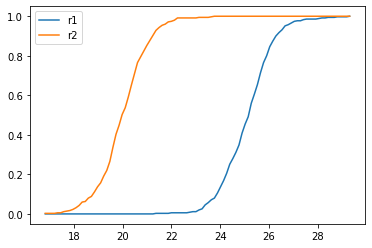

In [340]:
N = 350
M = 350
r2 = (stats.t.rvs(df=10, size=N)*0.9)+20
r1 = (stats.t.rvs(df=10, size=M)*0.9)+25
# r2 = (stats.t.rvs(df=10, size=M) + 10)
# r2 = r1

const = ((N*M/(N+M))**0.5)

n_grids = 100 # number of grid in grid search

R = 2000 # number of Bootstrap sample

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
# _min = 0
_max = np.max([np.max(r1), np.max(r2)])
income = np.linspace(_min, _max, n_grids) # grids

print(_min, _max)
ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

plt.plot(income, ecdf1(income), label='r1')
plt.plot(income, ecdf2(income), label='r2')
plt.legend()

# test for SOSD
j = 2

In [341]:
income_N_tensor = np.repeat(income[..., None], N, 1) # repeat for sample dimension
# income_N_tensor[0,0] == income_N_tensor[0,1] is True 

income_M_tensor = np.repeat(income[..., None], M, 1)

r1_tensor = np.repeat(r1[None, ...], n_grids, 0) # repeat for grid search dimension
r1_tensor = tf.constant(r1_tensor)

r2_tensor = np.repeat(r2[None, ...], n_grids, 0)
r2_tensor = tf.constant(r2_tensor)

# diff = I_tf(income_M_tensor, r2_tensor, j, M) - I_tf(income_N_tensor, r1_tensor, j, N) 

# S_hat = const*np.max(diff)

In [342]:
A = tf.cast(r1_tensor <= income_N_tensor, tf.float64)
B = tf.math.add(income_N_tensor, -r1_tensor)**(j-1)
C = tf.math.reduce_mean(A*B, axis=1)

D = tf.cast(r2_tensor <= income_M_tensor, tf.float64)
E = tf.math.add(income_M_tensor, -r2_tensor)**(j-1)
F = tf.math.reduce_mean(D*E, axis=1)

S_hat = const*tf.math.reduce_max(F-C, axis=0).numpy()
S_hat

67.68524402518665

In [343]:
id_mat_1 = [i for i in range(N)]
id_mat_1 = tf.constant([np.random.choice(id_mat_1, N, replace=True) for _ in range(R)])
id_mat_1 = tf.transpose(id_mat_1)
id_mat_1 = np.repeat(id_mat_1[None,...], n_grids, axis=0)

id_mat_2 = [i for i in range(M)]
id_mat_2 = tf.constant([np.random.choice(id_mat_2, M, replace=True) for _ in range(R)])
id_mat_2 = tf.transpose(id_mat_2)
id_mat_2 = np.repeat(id_mat_2[None,...], n_grids, axis=0)

income_N_tensor = np.repeat(income_N_tensor[..., None], R, 2) # repeat for MC dimension
income_M_tensor = np.repeat(income_M_tensor[..., None], R, 2)

In [344]:
id_mat_1.shape

(100, 350, 2000)

In [345]:
r1_tensor = r1[id_mat_1]
r2_tensor = r2[id_mat_2]

In [346]:
r1_tensor.shape

(100, 350, 2000)

In [347]:
A = tf.cast(r1_tensor <= income_N_tensor, tf.float64)
B = tf.math.add(income_N_tensor, -r1_tensor)**(j-1)
C = tf.math.reduce_mean(A*B, axis=1)

D = tf.cast(r2_tensor <= income_M_tensor, tf.float64)
E = tf.math.add(income_M_tensor, -r2_tensor)**(j-1)
F = tf.math.reduce_mean(D*E, axis=1)

S_bar = const*tf.math.reduce_max(F-C, axis=0).numpy()

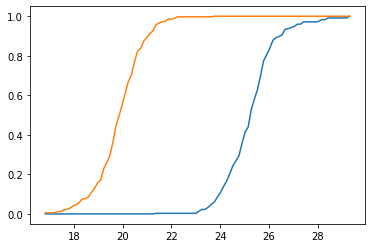

In [348]:
i=1
plt.plot(income, ECDF(r1_tensor[i,:,np.argmax(S_bar)])(income))
plt.plot(income, ECDF(r2_tensor[i,:,np.argmax(S_bar)])(income))
# plt.plot(income, ECDF(r1_tensor[i,:,20])(income))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


67.68524402518665


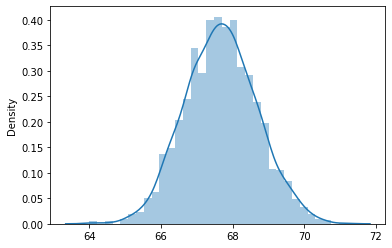

In [349]:
sns.distplot(S_bar)
print(S_hat)

In [350]:
p = np.mean(S_bar > S_hat) 

print('P-value =', p)

if p < 0.10:
  print("Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2")
else:
  print("Cannot reject Null; r2 is domaining r1 OR r2==r1")


P-value = 0.4925
Cannot reject Null; r2 is domaining r1 OR r2==r1


In [351]:
np.argmax(S_bar)

798

In [352]:
S_hat

67.68524402518665

In [278]:
diff = []

for z in income:
  I1 = scipy.integrate.quad(ecdf1, income[0],z)[0] 
  I2 = scipy.integrate.quad(ecdf2, income[0],z)[0] 
  diff.append(I2-I1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the inte

In [279]:
np.max(diff)

0.0

In [74]:
diff = []

for z in income:
  I1 = ecdf1(z)
  I2 = ecdf2(z)
  diff.append(I2-I1)

In [75]:
np.max(diff)

0.025714285714285717